In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import csv
from tqdm import tqdm

import tensorflow as tf
from tensorflow import shape,math
from tensorflow.keras import Input,layers,Model
from tensorflow.keras.losses import mse,binary_crossentropy
from tensorflow.keras.utils import plot_model

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

In [4]:
import os
import pandas as pd
import numpy as np

output_dir = os.path.join(".", "output_dance")  # Path to the output directory
subdirs = [f.path for f in os.scandir(output_dir) if f.is_dir()]
subdirs.sort()

# Create an empty 3D array to store the combined data
combined_arr = np.empty((len(subdirs), 1000, 10))

# Loop through each subdirectory and load the CSV files
for i, subdir in enumerate(subdirs):
    action_filename = os.path.join(subdir, "action.csv")
    obs_filename = os.path.join(subdir, "obs.csv")

    # Load the action and obs CSV files
    action_df = pd.read_csv(action_filename,  header=None)
    obs_df = pd.read_csv(obs_filename,  header=None)

    # Concatenate the DataFrames horizontally
    combined_data = pd.concat([action_df, obs_df], axis=1)

    # Convert combined_data to a 3D array and assign it to combined_arr
    combined_arr[i-1] = np.reshape(combined_data.values, (1000, 10))

# Print the shape of combined_arr
print(combined_arr.shape)
combined_tensor = torch.from_numpy(combined_arr)

(10000, 1000, 10)


In [3]:
# import torch

# combined_tensor = torch.from_numpy(combined_arr)
# print(combined_tensor.shape)
# flattened_tensor = combined_tensor.permute(2, 0, 1).flatten(start_dim=1)

# print(flattened_tensor.shape)


# VAE code -1

====> Epoch: 1 Average loss: 0.0036817602259772166, Recon Loss: 0.0019243502702031817, KL Div: 0.008787049736295427
====> Epoch: 2 Average loss: 0.002261675834655762, Recon Loss: 0.001922198304108211, KL Div: 0.0016973876527377537
====> Epoch: 3 Average loss: 0.002007249397890908, Recon Loss: 0.0019187329496656146, KL Div: 0.00044258217300687517
====> Epoch: 4 Average loss: 0.0019350663253239224, Recon Loss: 0.0019143105830465045, KL Div: 0.00010377876247678484
====> Epoch: 5 Average loss: 0.0019174816267830985, Recon Loss: 0.0019090913023267473, KL Div: 4.195166485650199e-05
====> Epoch: 6 Average loss: 0.0019072140880993435, Recon Loss: 0.0019029453141348703, KL Div: 2.1343831505094256e-05
====> Epoch: 7 Average loss: 0.0018984361461230686, Recon Loss: 0.0018957126481192453, KL Div: 1.3617472989218576e-05
====> Epoch: 8 Average loss: 0.0018889827813420978, Recon Loss: 0.0018869697110993522, KL Div: 1.0065385273524693e-05
====> Epoch: 9 Average loss: 0.001877417572907039, Recon Loss: 

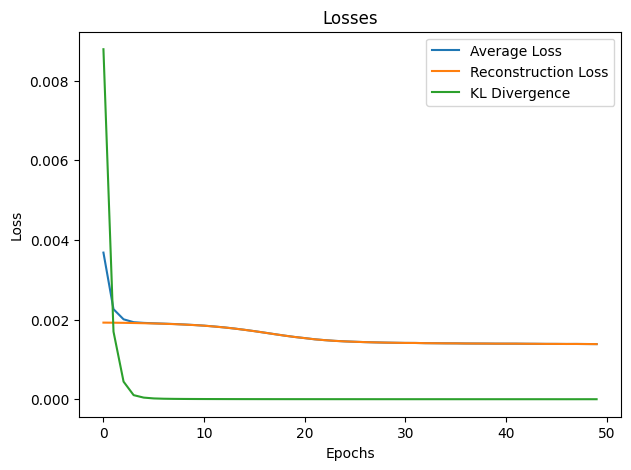

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, latent_dim * 2)  # mean and variance
        )

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)
        return mu, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_shape):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, output_shape),
        )

    def forward(self, z):
        x_reconstructed = self.decoder(z)
        return x_reconstructed


class VAE(nn.Module):
    def __init__(self, input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, input_shape)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var

    
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

# Assuming combined_tensor is your data
# Convert the data to float32
dataset = TensorDataset(combined_tensor.float())

# Define the data loader
batch_size = 512  # adjust as necessary

# Split data into train, validation, and test
train_size = int(0.7 * len(dataset))  # 70% for training
valid_size = int(0.15 * len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - valid_size  # 15% for testing

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Hyperparameters
input_shape = combined_tensor.shape[1] * combined_tensor.shape[2]  # modify this to match your data
hidden_dim1 = 512  # modify as needed
hidden_dim2 = 256  # modify as needed
hidden_dim3 = 24  # modify as needed
latent_dim = 2  # modify as needed
lr = 5e-5  # learning rate
n_epochs = 50  # modify as needed
beta = 0.2
    
# Model, optimizer, and loss function
model = VAE(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)

optimizer = optim.RAdam(model.parameters(), lr=lr)  # Make sure you're using the correct optimizer
loss_fn = nn.MSELoss()  # And the correct loss function


def train(epoch, model, optimizer, loss_fn, train_loader):
    model.train()
    train_loss = 0
    total_recon_loss = 0
    total_kl_div = 0
    for i, batch in enumerate(train_loader):  # using train_loader instead of dataloader
        batch_data = batch[0]  # get the data from the batch
        
        optimizer.zero_grad()

        # Flatten the data
        batch_data = batch_data.view(batch_data.size(0), -1)

        reconstructed_batch, mu, log_var = model(batch_data)

        # Loss: reconstruction loss + KL divergence
        recon_loss = loss_fn(reconstructed_batch, batch_data)
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + beta*kl_divergence

        loss.backward()
        train_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_div += kl_divergence.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_kl_div = total_kl_div / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss}, Recon Loss: {avg_recon_loss}, KL Div: {avg_kl_div}')

    return avg_loss, avg_recon_loss, avg_kl_div

    
import matplotlib.pyplot as plt

# Lists to store losses for each epoch
avg_losses = []
avg_recon_losses = []
avg_kl_divs = []

# Training
for epoch in range(1, n_epochs + 1):
    avg_loss, avg_recon_loss, avg_kl_div = train(epoch, model, optimizer, loss_fn, train_loader)
    avg_losses.append(avg_loss)
    avg_recon_losses.append(avg_recon_loss)
    avg_kl_divs.append(avg_kl_div)

# Plot the losses
plt.figure(figsize=(7,5))
plt.plot(avg_losses, label='Average Loss')
plt.plot(avg_recon_losses, label='Reconstruction Loss')
plt.plot(avg_kl_divs, label='KL Divergence')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [7]:
def evaluate(model, loss_fn, dataloader):
    model.eval()
    loss = 0
    total_recon_loss = 0
    total_kl_div = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            batch_data = batch[0]  # get the data from the batch

            # Flatten the data
            batch_data = batch_data.view(batch_data.size(0), -1)

            reconstructed_batch, mu, log_var = model(batch_data)

            # Loss: reconstruction loss + KL divergence
            recon_loss = loss_fn(reconstructed_batch, batch_data)
            kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss += recon_loss + kl_divergence
            total_recon_loss += recon_loss.item()
            total_kl_div += kl_divergence.item()

    avg_loss = loss / len(dataloader.dataset)
    avg_recon_loss = total_recon_loss / len(dataloader.dataset)
    avg_kl_div = total_kl_div / len(dataloader.dataset)

    return avg_loss, avg_recon_loss, avg_kl_div
evaluate(model, loss_fn, test_loader)

(tensor(0.0014), 0.0013796987533569336, 1.6032059987386067e-06)

# latent space plot

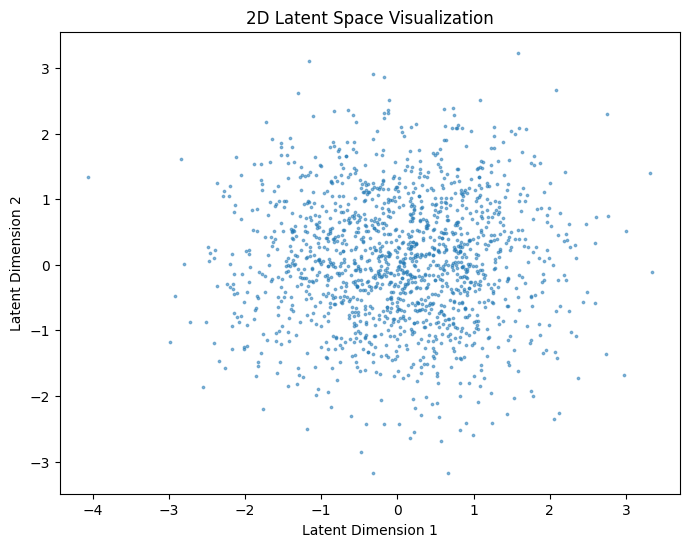

In [8]:
import numpy as np

# Get latent space representations for all data points
latent_vectors = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch_data = batch[0]
        batch_data = batch_data.view(batch_data.size(0), -1)
        mu, log_var = model.encoder(batch_data)
        z = model.reparameterize(mu, log_var)
        latent_vectors.append(z)

dance_latent_vectors = torch.cat(latent_vectors, dim=0).numpy()

# Plot the data in 2D latent space
plt.figure(figsize=(8, 6))
plt.scatter(dance_latent_vectors[:, 0], dance_latent_vectors[:, 1], alpha=0.5, s=3)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Latent Space Visualization')
plt.show()


In [9]:
with torch.no_grad():
    for batch in test_loader:
        batch_data = batch[0]
        batch_data = batch_data.view(batch_data.size(0), -1)
        mu, log_var = model.encoder(batch_data)
        print("mu is ", mu)
        print("log_var is ", log_var)

mu is  tensor([[-9.8053e-05, -3.4600e-05],
        [ 7.8570e-04,  5.9217e-05],
        [ 6.6132e-04, -1.4555e-04],
        ...,
        [-2.6560e-04, -5.4091e-05],
        [-6.4684e-04, -5.9437e-04],
        [-1.2456e-04,  7.6689e-04]])
log_var is  tensor([[-0.0006,  0.0008],
        [ 0.0010, -0.0003],
        [ 0.0005,  0.0004],
        ...,
        [-0.0002,  0.0027],
        [ 0.0003, -0.0017],
        [-0.0007, -0.0004]])
mu is  tensor([[-0.0001, -0.0003],
        [ 0.0004, -0.0006],
        [-0.0016, -0.0012],
        ...,
        [ 0.0002,  0.0005],
        [ 0.0007, -0.0002],
        [ 0.0015, -0.0001]])
log_var is  tensor([[ 3.0589e-04,  6.1555e-04],
        [-4.2917e-04, -2.1521e-03],
        [-9.2618e-04,  1.3118e-03],
        ...,
        [-9.5570e-04,  8.8096e-04],
        [ 7.3062e-04, -1.6856e-04],
        [ 6.2713e-04, -9.4801e-05]])
mu is  tensor([[-7.6643e-04,  6.3665e-04],
        [-6.1213e-04,  2.0450e-04],
        [-1.3063e-03,  6.1288e-04],
        [-1.1456e-03,  

/var/folders/dl/61k_wctj56gfxw96rry1rsgw0000gn/T/ipykernel_50168/4128912526.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(all_z[:, 0], all_z[:, 1], cmap='tab10')


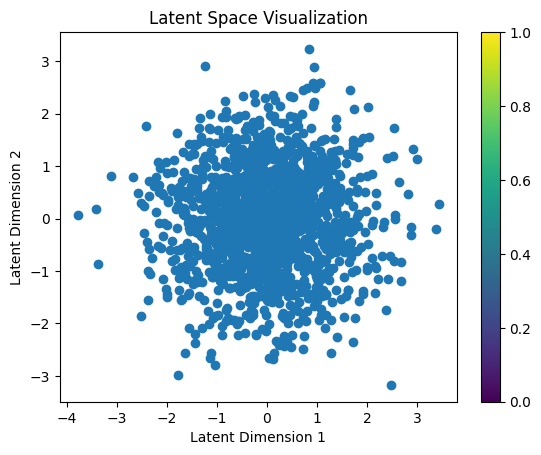

In [10]:
def plot_latent(vae, data_loader, num_batches=100):
    vae.eval()  # Set the VAE model to evaluation mode
    all_z = []

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            x = batch[0].view(batch[0].size(0), -1)  # Flatten the data

            mu, log_var = vae.encoder(x)
            z = vae.reparameterize(mu, log_var)

            all_z.append(z)

            if i >= num_batches:
                break

    all_z = torch.cat(all_z, dim=0).cpu().numpy()

    plt.scatter(all_z[:, 0], all_z[:, 1], cmap='tab10')
    plt.colorbar()
    plt.title('Latent Space Visualization')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()


plot_latent(model, test_loader)

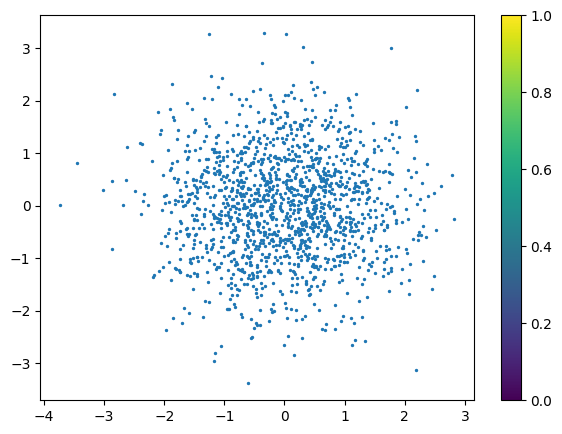

In [10]:
def plot_latent(model, data_loader):
    # Set the model to evaluation mode
    model.eval()
    latents = []
    for i, batch in enumerate(data_loader):
        x = batch[0]  # Get only the data (ignore the label)
        x = x.view(x.size(0), -1)
        mu, log_var = model.encoder(x)
        z = model.reparameterize(mu, log_var)
        latents.append(z.detach().cpu().numpy())
    latents = np.concatenate(latents, axis=0)
    plt.figure(figsize=(7,5))
    plt.scatter(latents[:, 0], latents[:, 1], s=2)
    plt.colorbar()
    plt.show()

# Call the function to plot latent representations
plot_latent(model, test_loader)


# render with action

In [14]:

import torch

# Convert combined_arr to PyTorch Tensor
# combined_tensor = torch.from_numpy(combined_arr)

# Print the shape of combined_tensor
print(combined_tensor.shape)

import matplotlib.pyplot as plt
from IPython import display
import gym


def replay(combined_data):

    action_sp = combined_data.iloc[:, :2]
    obs_sp = combined_data.iloc[:, 2:]

    env = gym.make('Swimmer-v3', render_mode = 'human')

    # Iterate through the rows
    for i in range(len(action_sp)):
        # Get the i-th row
        action = action_sp.iloc[i]
        observation = obs_sp.iloc[i]
        print(action)

        # If this is the first iteration, set the environment state to the given observation
        # Note: This assumes that the observation you've stored is the entire state that can be set with `env.reset()`
        # If this is not the case, you cannot simply set the environment state to the observation
        if i == 0:
            env.reset()  # We ignore the initial observation returned by `reset`

        # Apply the action
        next_observation, reward, done, trunc, info = env.step(action)
        # Render the environment
        env.render()
        # If you want to slow down each step for viewing, you can use time.sleep
        # time.sleep(0.01)

    # Close the environment
    env.close()


torch.Size([10000, 1000, 10])


# see the output

In [11]:
def test_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            batch_data = batch[0]  # get the data from the batch
            batch_data = batch_data.view(batch_data.size(0), -1)  # flatten the data
            reconstructed_batch, _, _ = model(batch_data)  # get reconstructed data from the model

            # Convert tensors to numpy arrays for use in pandas
            original_data = batch_data.detach().cpu().numpy()
            reconstructed_data = reconstructed_batch.detach().cpu().numpy()

            # Convert to dataframes
            original_df = pd.DataFrame(original_data)
            reconstructed_df = pd.DataFrame(reconstructed_data)

            if i == 0:  # for the first iteration, create the dataframes
                all_original_df = original_df
                all_reconstructed_df = reconstructed_df
            else:  # for subsequent iterations, append to the existing dataframes
                all_original_df = pd.concat([all_original_df, original_df])
                all_reconstructed_df = pd.concat([all_reconstructed_df, reconstructed_df])
    
    return all_original_df, all_reconstructed_df

# Call the function after training
original_df, reconstructed_df = test_model(model, test_loader)


In [12]:
original_df, reconstructed_df = test_model(model, valid_loader)

In [13]:
original_df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,1.0,-1.0,0.903756,-1.908173,1.924560,-0.062875,1.151996,-0.757714,1.444391,-1.503843,...,-1.000000,-1.000000,0.823817,-2.162001,1.872262,-0.092465,-0.041906,-0.035466,0.005555,0.044057
1,1.0,-1.0,0.631932,-1.872504,1.661220,-0.000423,1.037894,-0.799519,1.493302,-1.462734,...,-1.000000,-1.000000,0.928187,-1.935658,1.866924,-0.024930,0.054884,-0.003265,-0.027520,-0.029387
2,1.0,-1.0,0.864991,-1.718188,1.892399,-0.249008,1.093771,-0.755416,1.446514,-1.527275,...,1.000000,-0.949037,0.707442,-2.163952,2.054361,0.010680,-0.023277,0.003393,0.000258,0.000210
3,1.0,-1.0,0.802507,-1.816450,1.684298,-0.049444,1.143055,-0.812493,1.427270,-1.473580,...,1.000000,0.440562,0.816439,-2.106550,1.924518,-0.079739,0.043589,0.010100,-0.046357,0.037935
4,1.0,-1.0,0.935592,-2.063940,1.717671,-0.195258,1.149546,-0.825396,1.439429,-1.481104,...,-1.000000,1.000000,0.982365,-2.057828,1.975095,0.017873,-0.015755,0.016617,-0.009292,-0.027285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,1.0,-1.0,0.751043,-1.756803,1.851749,-0.115510,1.066963,-0.752930,1.495141,-1.531872,...,-0.989535,-1.000000,0.805471,-2.096259,1.878538,-0.043595,-0.032243,0.030157,0.025157,0.007279
472,1.0,-1.0,0.667350,-1.821169,1.825578,0.071762,1.085586,-0.787762,1.503438,-1.494968,...,1.000000,0.944859,0.765760,-2.118132,1.941424,-0.042753,-0.001814,-0.035874,-0.042727,0.042770
473,1.0,-1.0,0.641365,-1.882760,1.715743,0.117541,1.032711,-0.794002,1.500726,-1.505233,...,-1.000000,-1.000000,0.776674,-1.897530,2.009420,0.072495,-0.005288,0.002704,-0.046681,0.039213
474,1.0,-1.0,0.828576,-2.043328,1.791016,-0.001796,1.136268,-0.817927,1.501690,-1.534488,...,0.782940,1.000000,0.750964,-1.960441,1.856869,-0.072764,-0.032421,0.046411,0.023508,0.018200


In [14]:
reconstructed_df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.847099,-0.916869,0.690095,-1.556480,1.486594,-0.032808,0.953793,-0.695613,1.278107,-1.350324,...,0.182168,-0.014577,0.726521,-1.749732,1.650663,-0.013674,-0.004658,0.009494,-0.014349,0.006065
1,0.800758,-0.833262,0.642111,-1.392371,1.369171,-0.015200,0.842025,-0.641079,1.083308,-1.226847,...,0.181511,-0.008768,0.735753,-1.601821,1.457593,0.004273,-0.004713,0.010359,-0.014998,0.001158
2,1.076684,-1.111288,0.869424,-1.915027,1.858063,-0.011339,1.129987,-0.887286,1.501139,-1.724907,...,0.256993,-0.007476,0.942157,-2.185464,2.106750,-0.013285,-0.001823,0.013849,-0.005991,0.019411
3,0.827762,-0.894565,0.676368,-1.497521,1.443224,-0.032559,0.913574,-0.672589,1.214329,-1.322758,...,0.190257,-0.018806,0.739731,-1.709899,1.600283,-0.014656,-0.007899,0.012464,-0.005140,0.006985
4,1.341832,-1.400859,1.119412,-2.415746,2.397737,0.003084,1.461571,-1.148266,1.975867,-2.198237,...,0.314284,0.008224,1.119531,-2.786281,2.754894,-0.029566,-0.001235,0.000807,-0.005399,0.039670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,0.960084,-0.942236,0.680004,-1.812991,1.551433,-0.015805,1.061840,-0.717299,1.417916,-1.426106,...,0.182047,-0.006944,0.718192,-1.905650,1.761689,-0.011138,-0.011114,0.014458,-0.009981,0.014158
472,0.838352,-0.908334,0.684289,-1.537881,1.471620,-0.033208,0.940776,-0.688665,1.259043,-1.336303,...,0.184417,-0.015261,0.725728,-1.732060,1.628724,-0.014776,-0.005335,0.008801,-0.013763,0.006266
473,1.099425,-1.148412,0.847137,-2.006701,1.927525,-0.016746,1.281833,-0.873624,1.742592,-1.748660,...,0.165455,-0.022276,0.838226,-2.268617,2.231099,-0.010526,0.004577,0.000501,-0.017418,-0.003660
474,1.139151,-1.197239,0.940677,-2.034950,2.017255,-0.013441,1.247337,-0.955690,1.669748,-1.848517,...,0.262748,-0.006190,0.962736,-2.361854,2.298939,-0.019500,-0.003522,-0.004190,0.003124,0.021967


In [15]:
# Get the first row from the dataframe
first_row = reconstructed_df.iloc[0]

# Reshape it to (1000, 10)
reshaped_array = np.reshape(first_row.values, (1000, 10))

# Convert it back to a dataframe
reshaped_df = pd.DataFrame(reshaped_array)
recon_combined_tensor = torch.tensor(reshaped_df.values)


In [20]:
replay(reshaped_df)

/opt/homebrew/Caskroom/miniconda/base/envs/firstenv/lib/python3.11/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Swimmer-v3 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/firstenv/lib/python3.11/site-packages/gym/envs/mujoco/mujoco_env.py:190: UserWarning: WARN: This version of the mujoco environments depends on the mujoco-py bindings, which are no longer maintained and may stop working. Please upgrade to the v4 versions of the environments (which depend on the mujoco python bindings instead), unless you are trying to precisely replicate previous works).
  logger.warn(


0    0.851654
1   -0.855476
Name: 0, dtype: float32
Creating window glfw


/opt/homebrew/Caskroom/miniconda/base/envs/firstenv/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0   -0.163979
1   -0.862417
Name: 1, dtype: float32
0   -0.382332
1   -0.908479
Name: 2, dtype: float32
0   -0.553063
1   -0.845455
Name: 3, dtype: float32
0   -0.638307
1   -0.905927
Name: 4, dtype: float32
0   -0.511522
1   -0.924867
Name: 5, dtype: float32
0   -0.375559
1   -0.853432
Name: 6, dtype: float32
0   -0.349532
1   -0.900056
Name: 7, dtype: float32
0   -0.369700
1   -0.865977
Name: 8, dtype: float32
0   -0.522424
1   -0.816983
Name: 9, dtype: float32
0   -0.332674
1   -0.665287
Name: 10, dtype: float32
0   -0.386848
1   -0.354419
Name: 11, dtype: float32
0   -0.021046
1    0.066095
Name: 12, dtype: float32
0    0.791533
1    0.862135
Name: 13, dtype: float32
0    0.884638
1    0.886227
Name: 14, dtype: float32
0    0.857556
1    0.852967
Name: 15, dtype: float32
0    0.885387
1    0.554582
Name: 16, dtype: float32
0    0.880840
1    0.385136
Name: 17, dtype: float32
0    0.913413
1    0.475485
Name: 18, dtype: float32
0    0.910954
1    0.495520
Name: 19, dtype: float32
0 

2023-08-03 10:24:49.057 python[45905:6139168] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


0    0.914226
1    0.488303
Name: 91, dtype: float32
0    0.823132
1    0.462383
Name: 92, dtype: float32
0    0.852418
1    0.539909
Name: 93, dtype: float32
0    0.768870
1    0.586913
Name: 94, dtype: float32
0    0.670268
1    0.723824
Name: 95, dtype: float32
0    0.626534
1    0.801394
Name: 96, dtype: float32
0    0.507921
1    0.865126
Name: 97, dtype: float32
0    0.119288
1    0.875978
Name: 98, dtype: float32
0   -0.031024
1    0.829012
Name: 99, dtype: float32
0    0.564798
1    0.793369
Name: 100, dtype: float32
0    0.761916
1    0.702039
Name: 101, dtype: float32
0    0.814847
1    0.546297
Name: 102, dtype: float32
0    0.803923
1    0.348363
Name: 103, dtype: float32
0    0.666717
1   -0.010644
Name: 104, dtype: float32
0    0.592999
1   -0.642044
Name: 105, dtype: float32
0    0.308087
1   -0.880109
Name: 106, dtype: float32
0    0.158390
1   -0.907197
Name: 107, dtype: float32
0   -0.414930
1   -0.869025
Name: 108, dtype: float32
0   -0.778408
1   -0.891716
Name: 109

0    0.112843
1   -0.531513
Name: 290, dtype: float32
0   -0.006025
1   -0.633825
Name: 291, dtype: float32
0   -0.061678
1   -0.719757
Name: 292, dtype: float32
0   -0.364931
1   -0.807158
Name: 293, dtype: float32
0   -0.526083
1   -0.807157
Name: 294, dtype: float32
0   -0.641801
1   -0.778659
Name: 295, dtype: float32
0   -0.724520
1   -0.820454
Name: 296, dtype: float32
0   -0.752660
1   -0.789727
Name: 297, dtype: float32
0   -0.680491
1   -0.821679
Name: 298, dtype: float32
0   -0.662722
1   -0.772488
Name: 299, dtype: float32
0   -0.470030
1   -0.643388
Name: 300, dtype: float32
0   -0.370132
1   -0.407012
Name: 301, dtype: float32
0   -0.344246
1   -0.337389
Name: 302, dtype: float32
0   -0.285171
1   -0.300592
Name: 303, dtype: float32
0   -0.176558
1   -0.287970
Name: 304, dtype: float32
0   -0.049270
1   -0.261595
Name: 305, dtype: float32
0    0.024567
1   -0.190646
Name: 306, dtype: float32
0    0.224424
1   -0.083929
Name: 307, dtype: float32
0    0.523824
1    0.267343


0    0.472601
1    0.406207
Name: 458, dtype: float32
0    0.535458
1    0.426049
Name: 459, dtype: float32
0    0.597233
1    0.493938
Name: 460, dtype: float32
0    0.589046
1    0.496922
Name: 461, dtype: float32
0    0.622269
1    0.373954
Name: 462, dtype: float32
0    0.569598
1    0.197415
Name: 463, dtype: float32
0    0.505021
1    0.164402
Name: 464, dtype: float32
0    0.484129
1    0.114179
Name: 465, dtype: float32
0    0.335845
1    0.053238
Name: 466, dtype: float32
0    0.250734
1    0.075888
Name: 467, dtype: float32
0    0.085267
1    0.075146
Name: 468, dtype: float32
0   -0.005317
1    0.026284
Name: 469, dtype: float32
0    0.075083
1   -0.011852
Name: 470, dtype: float32
0    0.054811
1   -0.042473
Name: 471, dtype: float32
0    0.00825
1   -0.08938
Name: 472, dtype: float32
0   -0.054758
1   -0.116000
Name: 473, dtype: float32
0   -0.030397
1   -0.260404
Name: 474, dtype: float32
0   -0.039767
1   -0.456176
Name: 475, dtype: float32
0   -0.075950
1   -0.498965
Na

0    0.288974
1   -0.024702
Name: 613, dtype: float32
0    0.206785
1   -0.031351
Name: 614, dtype: float32
0    0.132506
1   -0.055591
Name: 615, dtype: float32
0    0.012422
1   -0.056354
Name: 616, dtype: float32
0   -0.079536
1   -0.080421
Name: 617, dtype: float32
0   -0.126490
1   -0.114983
Name: 618, dtype: float32
0   -0.042437
1   -0.084500
Name: 619, dtype: float32
0   -0.072221
1   -0.114596
Name: 620, dtype: float32
0   -0.072599
1   -0.131373
Name: 621, dtype: float32
0   -0.063953
1   -0.195676
Name: 622, dtype: float32
0   -0.038355
1   -0.300656
Name: 623, dtype: float32
0    0.037311
1   -0.376833
Name: 624, dtype: float32
0    0.075825
1   -0.359612
Name: 625, dtype: float32
0    0.042272
1   -0.324065
Name: 626, dtype: float32
0    0.025799
1   -0.323751
Name: 627, dtype: float32
0   -0.044600
1   -0.340493
Name: 628, dtype: float32
0   -0.039046
1   -0.303314
Name: 629, dtype: float32
0   -0.058118
1   -0.310068
Name: 630, dtype: float32
0   -0.035691
1   -0.266434


0    0.050868
1   -0.086100
Name: 770, dtype: float32
0    0.097669
1   -0.086132
Name: 771, dtype: float32
0    0.139214
1   -0.139346
Name: 772, dtype: float32
0    0.144372
1   -0.192109
Name: 773, dtype: float32
0    0.170099
1   -0.217393
Name: 774, dtype: float32
0    0.144677
1   -0.239716
Name: 775, dtype: float32
0    0.098898
1   -0.250136
Name: 776, dtype: float32
0    0.077451
1   -0.231904
Name: 777, dtype: float32
0    0.047803
1   -0.202733
Name: 778, dtype: float32
0   -0.028972
1   -0.173272
Name: 779, dtype: float32
0   -0.104228
1   -0.161275
Name: 780, dtype: float32
0   -0.079881
1   -0.096592
Name: 781, dtype: float32
0    0.000298
1   -0.065308
Name: 782, dtype: float32
0    0.064854
1    0.028161
Name: 783, dtype: float32
0    0.064425
1    0.046330
Name: 784, dtype: float32
0    0.107378
1    0.064779
Name: 785, dtype: float32
0    0.156484
1    0.037002
Name: 786, dtype: float32
0    0.153550
1   -0.014503
Name: 787, dtype: float32
0    0.209805
1   -0.078065


0    0.156970
1    0.054486
Name: 930, dtype: float32
0    0.153169
1    0.022209
Name: 931, dtype: float32
0    0.176800
1   -0.010096
Name: 932, dtype: float32
0    0.176495
1   -0.037830
Name: 933, dtype: float32
0    0.153367
1   -0.057101
Name: 934, dtype: float32
0    0.164359
1   -0.092344
Name: 935, dtype: float32
0    0.117609
1   -0.079646
Name: 936, dtype: float32
0    0.113001
1   -0.124602
Name: 937, dtype: float32
0    0.094990
1   -0.141522
Name: 938, dtype: float32
0    0.119383
1   -0.123906
Name: 939, dtype: float32
0    0.124356
1   -0.117479
Name: 940, dtype: float32
0    0.084954
1   -0.118194
Name: 941, dtype: float32
0    0.073023
1   -0.114871
Name: 942, dtype: float32
0    0.052372
1   -0.120758
Name: 943, dtype: float32
0    0.000210
1   -0.151834
Name: 944, dtype: float32
0   -0.021901
1   -0.191197
Name: 945, dtype: float32
0   -0.097649
1   -0.219601
Name: 946, dtype: float32
0   -0.093415
1   -0.265816
Name: 947, dtype: float32
0   -0.030779
1   -0.261702


In [17]:
# Get the first row from the dataframe
first_row = original_df.iloc[0]

# Reshape it to (1000, 10)
reshaped_array = np.reshape(first_row.values, (1000, 10))

# Convert it back to a dataframe
reshaped_df = pd.DataFrame(reshaped_array)
ori_combined_tensor = torch.tensor(reshaped_df.values)


In [22]:
replay(reshaped_df)

/opt/homebrew/Caskroom/miniconda/base/envs/firstenv/lib/python3.11/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Swimmer-v3 is out of date. You should consider upgrading to version `v4`.
  logger.warn(


0    1.0
1   -1.0
Name: 0, dtype: float32
Creating window glfw
0   -0.18688
1   -1.00000
Name: 1, dtype: float32
0   -0.448496
1   -1.000000
Name: 2, dtype: float32
0   -0.650864
1   -1.000000
Name: 3, dtype: float32
0   -0.769485
1   -1.000000
Name: 4, dtype: float32
0   -0.442615
1   -1.000000
Name: 5, dtype: float32
0   -0.425054
1   -1.000000
Name: 6, dtype: float32
0   -0.340424
1   -1.000000
Name: 7, dtype: float32
0   -0.612815
1   -1.000000
Name: 8, dtype: float32
0   -0.358603
1   -1.000000
Name: 9, dtype: float32
0   -0.772900
1   -0.815809
Name: 10, dtype: float32
0   -0.246261
1   -0.728583
Name: 11, dtype: float32
0   -0.406231
1   -0.106746
Name: 12, dtype: float32
0    1.0
1    1.0
Name: 13, dtype: float32
0    1.0
1    1.0
Name: 14, dtype: float32
0    1.0
1    1.0
Name: 15, dtype: float32
0    1.000000
1    0.639353
Name: 16, dtype: float32
0    1.000000
1    0.384963
Name: 17, dtype: float32
0    1.000000
1    0.450328
Name: 18, dtype: float32
0    1.000000
1    0.507

0    1.0
1    1.0
Name: 198, dtype: float32
0    1.0
1    1.0
Name: 199, dtype: float32
0    1.000000
1    0.895929
Name: 200, dtype: float32
0    1.000000
1    0.528622
Name: 201, dtype: float32
0    1.000000
1    0.434935
Name: 202, dtype: float32
0    1.000000
1    0.471247
Name: 203, dtype: float32
0    1.000000
1    0.477705
Name: 204, dtype: float32
0    1.000000
1    0.508928
Name: 205, dtype: float32
0    1.000000
1    0.641351
Name: 206, dtype: float32
0    1.0
1    1.0
Name: 207, dtype: float32
0    0.68903
1    1.00000
Name: 208, dtype: float32
0   -0.833552
1    1.000000
Name: 209, dtype: float32
0   -0.609472
1    1.000000
Name: 210, dtype: float32
0    1.0
1    1.0
Name: 211, dtype: float32
0    1.0
1    1.0
Name: 212, dtype: float32
0    1.0
1    1.0
Name: 213, dtype: float32
0    1.0
1    1.0
Name: 214, dtype: float32
0    1.000000
1    0.388677
Name: 215, dtype: float32
0    1.0
1   -1.0
Name: 216, dtype: float32
0    0.24382
1   -1.00000
Name: 217, dtype: float32
0   

0   -1.0
1   -1.0
Name: 440, dtype: float32
0   -1.0
1   -1.0
Name: 441, dtype: float32
0   -1.0
1   -1.0
Name: 442, dtype: float32
0   -0.989549
1   -1.000000
Name: 443, dtype: float32
0   -0.998459
1   -1.000000
Name: 444, dtype: float32
0   -1.0
1   -1.0
Name: 445, dtype: float32
0   -1.0
1   -1.0
Name: 446, dtype: float32
0   -1.0
1   -1.0
Name: 447, dtype: float32
0   -1.0
1   -1.0
Name: 448, dtype: float32
0   -1.0
1   -1.0
Name: 449, dtype: float32
0   -1.0
1   -1.0
Name: 450, dtype: float32
0   -1.0
1   -1.0
Name: 451, dtype: float32
0    0.615467
1   -0.681661
Name: 452, dtype: float32
0    1.0
1    1.0
Name: 453, dtype: float32
0    1.0
1    1.0
Name: 454, dtype: float32
0    1.0
1    1.0
Name: 455, dtype: float32
0    1.000000
1    0.644012
Name: 456, dtype: float32
0    1.000000
1    0.361703
Name: 457, dtype: float32
0    1.000000
1    0.370046
Name: 458, dtype: float32
0    1.000000
1    0.437486
Name: 459, dtype: float32
0    1.000000
1    0.485362
Name: 460, dtype: floa

0    1.000000
1    0.485464
Name: 676, dtype: float32
0    1.000000
1    0.602686
Name: 677, dtype: float32
0    1.000000
1    0.941518
Name: 678, dtype: float32
0    1.0
1    1.0
Name: 679, dtype: float32
0   -0.505543
1    1.000000
Name: 680, dtype: float32
0   -1.0
1    1.0
Name: 681, dtype: float32
0    1.0
1    1.0
Name: 682, dtype: float32
0    1.0
1    1.0
Name: 683, dtype: float32
0    1.0
1    1.0
Name: 684, dtype: float32
0    1.0
1    1.0
Name: 685, dtype: float32
0    1.000000
1    0.361827
Name: 686, dtype: float32
0    1.0
1   -1.0
Name: 687, dtype: float32
0    0.207513
1   -1.000000
Name: 688, dtype: float32
0    0.819491
1   -1.000000
Name: 689, dtype: float32
0   -0.563537
1   -1.000000
Name: 690, dtype: float32
0   -1.0
1   -1.0
Name: 691, dtype: float32
0   -1.0
1   -1.0
Name: 692, dtype: float32
0   -1.0
1   -1.0
Name: 693, dtype: float32
0   -1.0
1   -1.0
Name: 694, dtype: float32
0   -0.987878
1   -1.000000
Name: 695, dtype: float32
0   -0.998158
1   -1.000000
Na

0   -1.0
1   -1.0
Name: 919, dtype: float32
0    0.608320
1   -0.704617
Name: 920, dtype: float32
0    1.0
1    1.0
Name: 921, dtype: float32
0    1.0
1    1.0
Name: 922, dtype: float32
0    1.0
1    1.0
Name: 923, dtype: float32
0    1.000000
1    0.648983
Name: 924, dtype: float32
0    1.000000
1    0.367119
Name: 925, dtype: float32
0    1.000000
1    0.374276
Name: 926, dtype: float32
0    1.000000
1    0.439734
Name: 927, dtype: float32
0    1.000000
1    0.485429
Name: 928, dtype: float32
0    1.000000
1    0.602231
Name: 929, dtype: float32
0    1.000000
1    0.940136
Name: 930, dtype: float32
0    1.0
1    1.0
Name: 931, dtype: float32
0   -0.503006
1    1.000000
Name: 932, dtype: float32
0   -1.0
1    1.0
Name: 933, dtype: float32
0    1.0
1    1.0
Name: 934, dtype: float32
0    1.0
1    1.0
Name: 935, dtype: float32
0    1.0
1    1.0
Name: 936, dtype: float32
0    1.0
1    1.0
Name: 937, dtype: float32
0    1.000000
1    0.365453
Name: 938, dtype: float32
0    1.0
1   -1.0
Na

In [23]:
recon_combined_tensor-ori_combined_tensor

tensor([[-0.1483,  0.1445,  0.0419,  ...,  0.1236, -0.2747,  0.1415],
        [ 0.0229,  0.1376,  0.0355,  ...,  0.0450, -0.1495,  0.2381],
        [ 0.0662,  0.0915,  0.0648,  ...,  0.0026, -0.0804,  0.2156],
        ...,
        [-0.8255, -0.4163, -1.0753,  ...,  1.0046, -1.2429, -0.2478],
        [-0.8354, -0.4071, -0.9028,  ...,  1.1417, -1.4299, -0.2264],
        [-0.7927, -0.4365, -0.0643,  ...,  0.0263, -0.0320,  0.0341]])

In [24]:
# Flatten the tensors
flattened_ori = ori_combined_tensor.flatten()
flattened_recon = recon_combined_tensor.flatten()

# Calculate the Euclidean distance
euclidean_distance = torch.norm(flattened_ori - flattened_recon)


print(euclidean_distance)


tensor(72.6843)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_data(original_df, reconstructed_df):
    num_columns = original_df.shape[1]

    # Create subplots to visualize each column separately
    fig, axes = plt.subplots(nrows=num_columns, ncols=2, figsize=(10, 5*num_columns))
    fig.suptitle('Original Data vs. Reconstructed Data', fontsize=16)

    for i in range(num_columns):
        # Plot original data
        axes[i, 0].scatter(range(len(original_df)), original_df[i], label='Original', s=10)
        axes[i, 0].set_ylabel(f'Column {i+1}')
        axes[i, 0].legend()

        # Plot reconstructed data
        axes[i, 1].scatter(range(len(reconstructed_df)), reconstructed_df[i], label='Reconstructed', s=10)
        axes[i, 1].set_ylabel(f'Column {i+1}')
        axes[i, 1].legend()

    plt.xlabel('Data Index')
    plt.show()

# Call the function after training
original_df, reconstructed_df = test_model(model, test_loader)
compare_data(original_df, reconstructed_df)
